## Install hopsworks

## Imports

In [25]:
%pip uninstall hopsworks hsfs hsml -y

%pip install hopsworks

Found existing installation: hopsworks 4.1.4
Uninstalling hopsworks-4.1.4:
  Successfully uninstalled hopsworks-4.1.4
Note: you may need to restart the kernel to use updated packages.
  Using cached hopsworks-4.1.4-py3-none-any.whl.metadata (11 kB)
Using cached hopsworks-4.1.4-py3-none-any.whl (640 kB)
Note: you may need to restart the kernel to use updated packages.


In [26]:
import os
import requests

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score

import hopsworks
import json
import warnings
warnings.filterwarnings("ignore")

## Read data from Hopsworks

In [27]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store()

movie_fg = fs.get_feature_group(
    name='tmdb_movies',
    version=1,
)

genres_fg= fs.get_feature_group(
    name='tmdb_movie_genres',
    version=1,
)

selected_features = movie_fg.select(['title','release_year', 'runtime', 'budget',
                                     'original_language', 'imdb_rating',
                                     'production_countries', 'imdb_votes']).join(genres_fg.select_all(), on=['id'])


2025-01-05 20:45:08,962 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-05 20:45:08,968 INFO: Initializing external client
2025-01-05 20:45:08,968 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-05 20:45:10,263 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559


In [28]:
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.25s) 


,title,release_year,runtime,budget,original_language,imdb_rating,production_countries,imdb_votes,id,timestamp,...,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,Moscow Heat,2004,89.0,0.0,en,2.5,Russia,2438.0,106546,2025-01-05 00:00:00+00:00,...,0,0,0,0,0,0,0,1,0,0
1,A Killing Affair,1977,100.0,0.0,en,6.1,United States of America,125.0,5526,2025-01-05 00:00:00+00:00,...,0,0,0,0,0,0,1,0,0,0
2,Top Secret,1952,93.0,0.0,en,6.3,United Kingdom,201.0,194432,2025-01-05 00:00:00+00:00,...,0,0,0,0,0,0,0,0,0,0
3,The Man Who Could Work Miracles,1936,82.0,0.0,en,6.9,United Kingdom,1647.0,68849,2025-01-05 00:00:00+00:00,...,0,0,0,0,0,0,0,0,0,0
4,Them Who?,2015,95.0,0.0,it,6.4,Italy,1910.0,369230,2025-01-05 00:00:00+00:00,...,0,0,0,0,0,0,0,0,0,0
5,She Freak,1967,83.0,0.0,en,3.6,United States of America,1259.0,30935,2025-01-05 00:00:00+00:00,...,0,1,0,0,0,0,0,0,0,0
6,More Than Meets the Eye: The Joan Brock Story,2003,120.0,0.0,en,6.4,Canada,181.0,113192,2025-01-05 00:00:00+00:00,...,0,0,0,0,0,0,1,0,0,0
7,Five,1951,93.0,0.0,en,6.3,United States of America,1693.0,48481,2025-01-05 00:00:00+00:00,...,0,0,0,0,0,1,0,0,0,0
8,The Manitou,1978,104.0,0.0,en,5.4,"Canada, United States of America",3452.0,40060,2025-01-05 00:00:00+00:00,...,0,1,0,0,0,1,0,0,0,0
9,Cold Feet,1989,94.0,0.0,en,4.8,United States of America,477.0,88658,2025-01-05 00:00:00+00:00,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Creating a feature view
feature_view = fs.get_or_create_feature_view(
    name='tmdb_fv',
    description="movie features with imdb rating as the target",
    version=2,
    labels=['imdb_rating'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1169559/fs/1160262/fv/tmdb_fv/version/2


In [30]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2, random_state=48)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.13s) 


In [31]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Label encoding categorical features

X_train['production_countries'] = label_encoder.fit_transform(X_train['production_countries'])
X_train['original_language'] = label_encoder.fit_transform(X_train['original_language'])

X_test['production_countries'] = label_encoder.fit_transform(X_test['production_countries'])
X_test['original_language'] = label_encoder.fit_transform(X_test['original_language'])

#X_train.head()
print(X_train['production_countries'].unique())
print(X_train['original_language'].unique())

[1265 1208  258 ...  322 1213 1061]
[13 27 22 33 61 28 48 62 19  7 58 59 14 10 11 39 25 45 44 50 64  6 60 12
 18 41 70  2 15 32 21 46  1  8 23 54 26 65 43 35 29 36 17  4 16 71 68 38
 34 47 20  3 67 63 55 24 49 66 53 69  9 56 37 51  0 52 42 30 40 57 31  5]


# Training models
XGBoost, RandomForest, Linear Regression, SVR, DecisionTree

In [39]:
from xgboost import XGBRegressor

xgb_model= XGBRegressor()
rf_model= RandomForestRegressor(random_state=48)
lr_model= LinearRegression()
svr_model= SVR()
dt_model= DecisionTreeRegressor(random_state=48)

models={
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Linear Regression": lr_model,
    "SVR": svr_model,
    "Decision Tree": dt_model
}

model_scores_MSE={
    "XGBoost": 0,
    "Random Forest": 0,
    "Linear Regression": 0,
    "SVR": 0,
    "Decision Tree": 0
}

model_scores_r2={
    "XGBoost": 0,
    "Random Forest": 0,
    "Linear Regression": 0,
    "SVR": 0,
    "Decision Tree": 0
}

## With categorical features
Removed production countries as they could have several values and majority had the U.S

In [40]:
with_cat=['id', 'title','timestamp', 'production_countries']

train_features= X_train.drop(with_cat, axis=1)
test_features = X_test.drop(with_cat, axis=1)

for name, model in models.items():
    model.fit(train_features, y_train)
    print(name)
    y_pred= model.predict(test_features)
    mse= mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)
    print('_________')

XGBoost
MSE: 0.7668853418281579
R squared: 0.40856703942605654
_________
Random Forest
MSE: 0.6370895068066901
R squared: 0.508667446605459
_________
Linear Regression
MSE: 0.8564045858914928
R squared: 0.3395285161202045
_________
SVR
MSE: 1.2711218279191314
R squared: 0.019692638609811075
_________
Decision Tree
MSE: 1.2681466355503694
R squared: 0.021987149581606635
_________


## Without categorical features
Removed original language as well since half of the dataset had "en" (english). Removing this feature led to a lower MSE.

In [41]:
drop_list=['id', 'title','timestamp', 'original_language', 'production_countries']

print("Dropped:", drop_list, "\n")
train_features= X_train.drop(drop_list, axis=1)
test_features = X_test.drop(drop_list, axis=1)

for name, model in models.items():
    model.fit(train_features, y_train)
    print(name)
    y_pred= model.predict(test_features)
    mse= mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)
    print('_________')
    models[name]= model
    model_scores_MSE[name]= mse
    model_scores_r2[name]= r2

Dropped: ['id', 'title', 'timestamp', 'original_language', 'production_countries'] 

XGBoost
MSE: 0.6047048324167154
R squared: 0.5336429713769023
_________
Random Forest
MSE: 0.6194480554259043
R squared: 0.5222727866085508
_________
Linear Regression
MSE: 0.8732498317379562
R squared: 0.3265372212301241
_________
SVR
MSE: 1.2711763512574825
R squared: 0.019650589430275978
_________
Decision Tree
MSE: 1.1555484247374563
R squared: 0.10882450263057464
_________


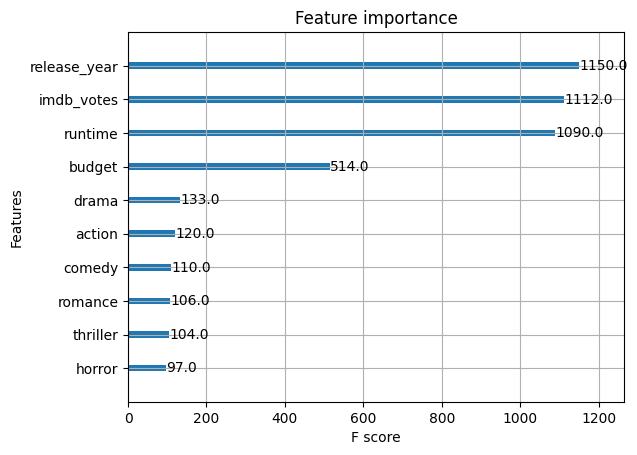

In [42]:
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10)
plt.show()

In [43]:
name="XGBoost"
model = models[name]
r2 = model_scores_r2[name]
mse = model_scores_MSE[name]

In [44]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [45]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [49]:
mr = project.get_model_registry()

model_dir="model"
model.save_model(model_dir + "/model.json")

# Creating a Python model in the model registry named 'imdb_rating_model'

movie_rating_pred_model = mr.python.create_model(
    name="movie_rating_model",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Movie Rating (1 to 10) predictor",
)

# Saving the model artifacts to the model registry
movie_rating_pred_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/585192 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/0 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/146 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2128 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1169559/models/movie_rating_model/1


Model(name: 'movie_rating_model', version: 1)